In [1]:
import collections
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import seaborn as sns

import networkx as nx
from networkx.algorithms import community
import graph_tool.all as gt

import cc_graph_ops

In [2]:
INPUT_FILE = 'fdg_input_file.json'

In [3]:
g = cc_graph_ops.create_graph_from_file(INPUT_FILE, format='gt')

In [4]:
def normalize(g, vp, inplace=False, translate_min=False):
    """Given a positive-valued VertexPropertyMap, computes the normalized VertexPropertyMap"""
    assert vp.value_type() in ['double', 'int'], 'not a numeric property map'
    if translate_min:
        # min_vp = min(vp[v] for v in g.vertices())
        min_vp = np.min(vp.get_array())
        if inplace:
            for v in g.vertices():
                vp[v] -= min_vp
        else:
            translated_vp = g.new_vp('double')
            for v in g.vertices():
                translated_vp[v] = vp[v] - min_vp
            vp = translated_vp
    total = np.sum(vp.get_array())
    if inplace:
        for v in g.vertices():
            vp[v] /= total
        return vp
    else:
        pers = g.new_vp('double')
        for v in g.vertices():
            pers[v] = vp[v]/total
        return pers

In [5]:
def get_licenses_vp(g, license=None):
    pers = g.new_vp('double')
    total = 0
    for v in g.vertices():
        if isinstance(g.vp['cc_licenses'][v], dict):
            if license is None:
                pers[v] = sum(g.vp['cc_licenses'][v].values())
            elif license in g.vp['cc_licenses'][v]:
                pers[v] = g.vp['cc_licenses'][v][license]
            else:
                pers[v] = 0
        else:
            pers[v] = 0
        total += pers[v]
    if license is None:
        g.vp['num_licenses'] = pers
    return normalize(g, pers)

In [6]:
def log_log_linreg(g, degree_vp, num_licenses, show_chart=False, save_fig=False):
    x, y = [], []
    for v in g.vertices():
        x.append(math.log(1 + degree_vp[v]))
        y.append(math.log(1 + num_licenses[v]))
      
    if show_chart:
        plt.scatter(x, y)
        plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), 'r')
        plt.xlabel('log (DEGREE)')
        plt.ylabel('log (LICENSES)')
        if save_fig:
            plt.savefig(save_fig)
        plt.show()
    
    slope, intercept, r_val, p_val, _ = scipy.stats.linregress(x, y)
    def compute_residual(deg, actual):
        transformed_pred = slope * math.log(1 + deg) + intercept
        pred = math.exp(transformed_pred) - 1
        return actual - pred
    return compute_residual

In [7]:
def get_residuals_vp(g, degree='total', show_chart=False, save_fig=False):
    if 'num_licenses' not in g.vp:
        _ = get_licenses_vp(g)
    
    assert g.ep['weight'], "Weight edge property map not found"
    assert degree in ['total', 'in', 'out'], "Choose one of ['total', 'in', 'out']"
    assert 'num_licenses' in g.vp, 'Vertex property map for num_licenses not found'
    
    degree_vp = g.degree_property_map(degree, weight=g.ep['weight'])
    num_licenses = g.vp['num_licenses']
    
    compute_residual = log_log_linreg(g, degree_vp, num_licenses, show_chart=show_chart, save_fig=save_fig)
    residual = g.new_vp('double')
    for v in g.vertices():
        residual[v] = compute_residual(degree_vp[v], num_licenses[v])
    return normalize(g, residual, translate_min=True)

In [8]:
def get_sorted_ranks(g, pers=None, damping=0.85):
    vranks = gt.pagerank(g, pers=pers, weight=g.ep['weight'], damping=damping)
    ranks = {g.vp['id'][v]: vranks[v] for v in g.vertices()}
    return sorted(ranks.items(), key=lambda x: x[1], reverse=True)

## Computing PageRank

In [9]:
INPUT_FILE = 'fdg_input_file.json'

First, we compute PageRank using the number of licenses within a domain for personalization.

In [10]:
sorted_ranks = get_sorted_ranks(g)

In [11]:
pers = get_licenses_vp(g)
sorted_ranks_cc_pers = get_sorted_ranks(g, pers)

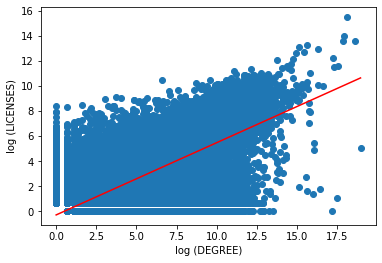

In [12]:
res_pers = get_residuals_vp(g, show_chart=True)
sorted_ranks_res_pers = get_sorted_ranks(g, res_pers)

In [13]:
display(scipy.stats.describe(pers.get_array()))
display(scipy.stats.describe(res_pers.get_array()))

DescribeResult(nobs=235863, minmax=(0.0, 0.12511954834143443), mean=4.239749346018663e-06, variance=7.59280977890651e-08, skewness=405.42521217522886, kurtosis=180924.9057412861)

DescribeResult(nobs=235863, minmax=(0.0, 0.0005404638883851089), mean=4.2397493460186655e-06, variance=1.3874751269646708e-12, skewness=408.1230413756945, kurtosis=182759.7182836067)

In [14]:
print('Not Personalized' + ' ' * 24 + 'CC Personalized' + ' ' * 25 +  'Residual Personalized')
template = '{:<20}{:>10.4f}' + ' ' * 10 + '{:<20}{:>10.4f}' + ' ' * 10 + '{:<20}{:>10.4f}'
rows = 30
for r1, r2, r3 in zip(sorted_ranks[:rows], sorted_ranks_cc_pers[:rows], sorted_ranks_res_pers[:rows]):
    print(template.format(*r1, *r2, *r3))

Not Personalized                        CC Personalized                         Residual Personalized
twitter                 0.0593          wikipedia               0.0800          twitter                 0.0593
github                  0.0561          wikimedia               0.0546          github                  0.0561
google                  0.0555          twitter                 0.0493          google                  0.0554
facebook                0.0412          google                  0.0490          facebook                0.0412
wikipedia               0.0384          github                  0.0483          wikipedia               0.0386
wikimedia               0.0305          facebook                0.0313          wikimedia               0.0306
youtube                 0.0227          mediawiki               0.0246          youtube                 0.0227
wordpress               0.0186          stackexchange           0.0210          wordpress               0.0185
flickr    

Determining the Domains that are Significantly Boosted by Residual Personalization

In [15]:
vranks_no_pers = gt.pagerank(g, weight=g.ep['weight'])
vranks_res_pers = gt.pagerank(g, pers=res_pers, weight=g.ep['weight'])

In [16]:
raw_diff = []
diff = []
greatly_moved = []
for v in g.vertices():
    new_elem = (vranks_res_pers[v] - vranks_no_pers[v])/vranks_no_pers[v]
    if new_elem > 0.20:
        greatly_moved.append(v)
    diff.append(new_elem)
    raw_diff.append(vranks_res_pers[v] - vranks_no_pers[v])

In [17]:
print([g.vp['id'][v] for v in greatly_moved])

['dmpl', 'wilmlibrary', 'medias', 'alienplantsbelgium', 'izdatsovet', 'bates', 'politplatschquatsch', 'lbhf', 'accordo', 'mshsaa', 'vaughanpl', 'hcpl', 'lapinturera', 'webdeb', 'toidicodedao', 'wikicfp', 'subject', 'tp-linkru', 'musee-mccord', 'marilynsclosetblog', 'gamesx', 'conicet', 'i-divadlo', 'publicdomainfiles', 'igem', 'entrebrochasypaletas', 'fudan', 'umsl', 'tku', 'naukowy', 'socialsuriname', 'slcolibrary', 'nesc', 'ipipan', 'etu', 'boxfordlibrary', 'audio-lingua', 'infoarena', 'buala', 'compilgames', 'zkoss', 'laredolibrary', 'kasahorow', 'acideformik', 'oxwall', 'ula', 'sccl', 'ihacom', 'fieldtriptoolbox', 'georgetownpl', 'unigre', 'video-bookmark', 'expose', 'scssoft', 'rcls', 'alchetron', 'smcl', 'mymcpl', 'embrapa', 'museum-digital', 'metalorgie', 'getsongbpm', 'forth-ev', 'wikifur', 'tscpl', 'wccls', 'stevensmemlib', 'cmlibrary', 'popflock', 'colmex', 'iku', 'cite-sciences', 'geeksofdoom', 'smb-digital', 'unionpedia', 'uni-greifswald', 'peoplepower21', 'seedfinder', 'ph

## Subgraph Pagerank

It may also be interesting to consider the major players within the subgraphs induced by different licenses. We say a domain belongs to the subgraph for a given license if more than a specified threshold of the content on that node use that license type.

In [4]:
licenses = cc_graph_ops.get_licenses(g)

In [5]:
# tunable parameters
proportion = 0.3
quota = 10
min_subgraph_size = 100

In [6]:
subgraph_by_license = cc_graph_ops.all_license_subgraphs(g, licenses, quota, proportion)

In [7]:
licenses = sorted(licenses, key=lambda x: -len(list(subgraph_by_license[x].vertices())))

In [13]:
def subgraph_sorted_ranks(subgraph, license):
    pers = get_licenses_vp(g, license)
    return get_sorted_ranks(subgraph, pers=pers)

In [14]:
license_subgraph_vranks = dict()
for license in licenses:
    pers = get_licenses_vp(g, license)
    sorted_ranks = get_sorted_ranks(subgraph_by_license[license], pers=pers)
    license_subgraph_vranks[license] = sorted_ranks

In [15]:
pers = get_licenses_vp(g)
vranks = gt.pagerank(g, pers=pers, weight=g.ep['weight'])

In [16]:
license_vranks = collections.defaultdict(list)
for v in g.vertices():
    for license in licenses:
        cc_licenses = g.vp['cc_licenses'][v]
        if isinstance(cc_licenses, dict):
            total_licenses = sum(cc_licenses.values())
            if (license in cc_licenses
                    and cc_licenses[license] >= proportion * total_licenses
                    and cc_licenses[license] >= quota):
                license_vranks[license].append((g.vp['id'][v], vranks[v]))

In [17]:
for license in licenses:
    if len(list(subgraph_by_license[license].vertices())) > min_subgraph_size:
        print(license)
        print('subgraph size:\t\t', len(list(subgraph_by_license[license].vertices())))
        print('Subgraph Top 10\t\t Global Top 10')
        print('---------------------------------------')
        license_vranks[license].sort(key=lambda x: -x[1])
        for (d1, _), (d2, _) in zip(license_subgraph_vranks[license][:10], license_vranks[license][:10]):
            print(f"{d1:<25}{d2}")
        print('\n')

('by', '4.0')
subgraph size:		 9085
Subgraph Top 10		 Global Top 10
---------------------------------------
google                   google
apigee                   bibfra
bibfra                   data
medium                   medium
tensorflow               apigee
web                      hexo
rada                     bepress
library                  library
kmu                      arxiv
crossref                 www


('by-nc-sa', '4.0')
subgraph size:		 8146
Subgraph Top 10		 Global Top 10
---------------------------------------
php                      php
amazonaws                amazonaws
vamworld                 andreashelbig
jisc                     iha
ox                       ox
uwaterloo                freenode
cantusindex              jisc
sourcewatch              dhm
middleeastmonitor        hdg
xfce                     biodiversitylibrary


('by-nc-nd', '4.0')
subgraph size:		 7387
Subgraph Top 10		 Global Top 10
---------------------------------------
daum               